# Data Science Wordclouds

This is a notebook for testing all of the functions to go through an entire data science workflow of running NLP on chosen subreddits.

**Future**
- DF functions should be removed from workflow and imported using a class.
- Multiple example DS outcomes would be nice.

---

In [1]:
!pwd

/Users/chris/github/reddit_nlp


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from PIL import Image
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint

In [3]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit

In [4]:
!pwd

/Users/chris/github/reddit_nlp/util


In [7]:
subreddit_list = ['python', 'java', 'pandas']

In [8]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful


In [9]:
df.sample(10)

,title,subreddit,date
5389,regular expressions pattern match in python 3.8,python,2020-04-10
3860,yes.,pandas,2020-04-10
2342,JVM Ecosystem Report 2020,java,2020-04-02
1584,Github Action (and CLI!) to monitor your docke...,python,2020-03-29
2640,What happened to TomEE?,java,2020-04-02
5468,How to select a character from text,python,2020-04-10
4689,What is the most interesting thing you learned...,java,2020-04-10
1953,brussels,pandas,2020-04-02
5170,I made a thing and put it on PYPI,python,2020-04-10
5413,Is there a way to add the letters with accents...,python,2020-04-10


In [10]:
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [11]:
# NOTE ### this does not use the X value inputted when using split...


def make_cloud(text_column, labels_column=None, height=300, width=800, max_words=100, split=None, stopwords=None, colormap='viridis', background_color='black'):
    '''
    Inputs:
    X: text input
    height: height of each wordcloud
    width: width of each wordcloud
    max_words: max words for each wordcloud
    split: if True, wordcloud for each subreddit
    labels: must provide list of labels if split=True, to generate a wordcloud for each label
    stopwords: usually these are the same stopwords used by the tranformer (CountVectorizer or Tfidf)
    colormap: any choice from matplotlib gallery.  Find them with plt.cm.datad
        'random': picks a random colormap for each cloud.
    '''

    colormaps = [m for m in plt.cm.datad if not m.endswith("_r")]
    wc = wordcloud.WordCloud(max_words=max_words,
                             width=width,
                             height=height,
                             background_color=background_color,
                             colormap=np.random.choice(
                                 colormaps) if colormap == 'random' else colormap,
                             stopwords=stopwords)
    if split:
        unique_labels = df[labels_column].unique()
        for label in unique_labels:
            cloud = wc.generate(
                df[df[labels_column] == label][text_column].str.cat())
            plt.figure(figsize=(width/100, height*len(unique_labels)/100), dpi=100)
            plt.title(label.upper(), fontdict={'fontsize': 15})
            plt.axis("off")
            plt.imshow(cloud.to_image(), interpolation='bilinear')

    else:
        cloud = wc.generate(df[text_column].str.cat())
        return cloud.to_image()

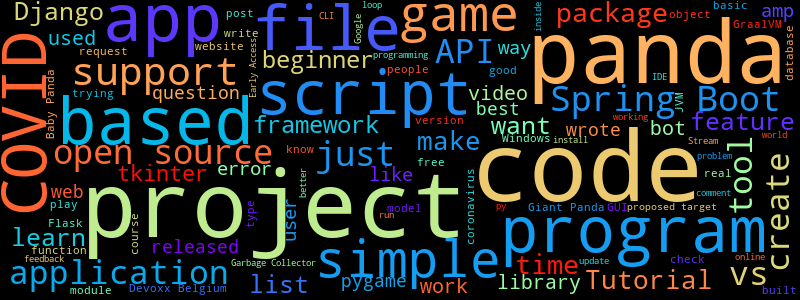

In [12]:
make_cloud(text_column='title', stopwords=custom_stop_words, colormap='rainbow')

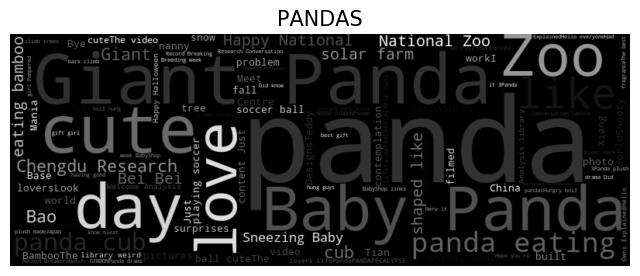

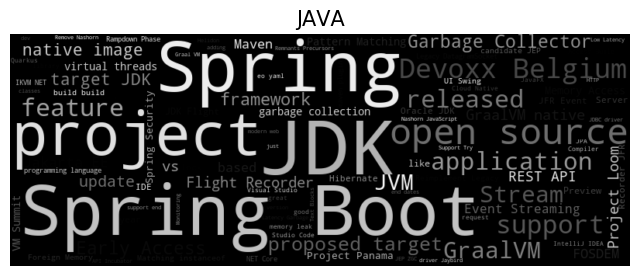

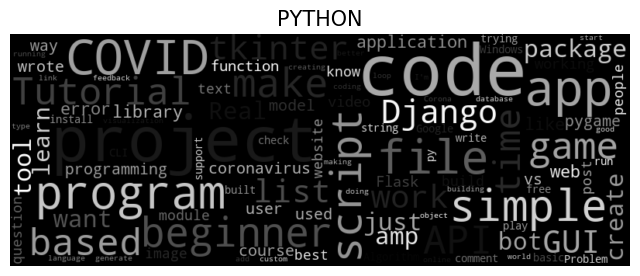

In [13]:
make_cloud(text_column='title', labels_column='subreddit', split=True, stopwords=custom_stop_words, colormap='random', background_color='black')

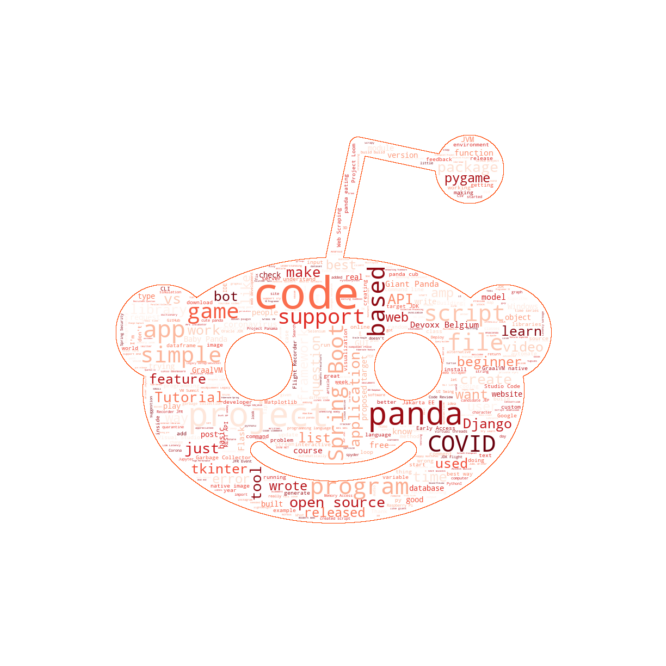

In [15]:
img = Image.open('../images/reddit03.png')
gray = np.array(img.convert('L'))
mask = np.where(gray < 200, 255, 0)

wc = wordcloud.WordCloud(background_color='white', 
                         max_words=500, 
                         mask=mask, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc.generate(df['title'].str.cat())
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis(False);

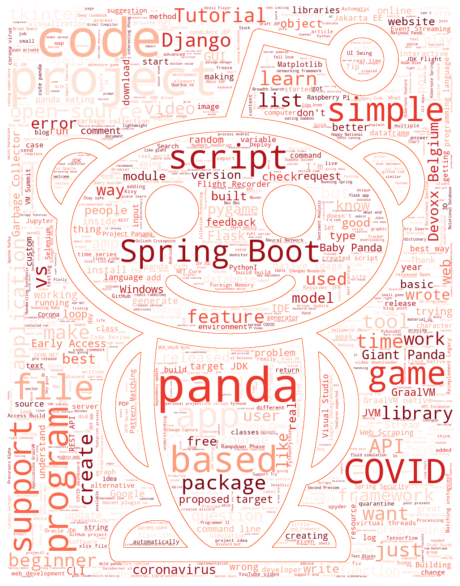

In [16]:
img2 = Image.open('../images/reddit02.jpg')
gray2 = np.array(img2.convert('L'))
mask2 = np.where(gray2 < 200, 255, 0)

wc2 = wordcloud.WordCloud(background_color='white', 
                         max_words=1000, 
                         mask=mask2, 
                         colormap='Reds',
                         contour_color='orangered',
                         contour_width=1,
                         stopwords=custom_stop_words)
wc2.generate(df['title'].str.cat())
plt.figure(figsize=(8,12))
plt.imshow(wc2, interpolation='bilinear')
plt.axis(False)

plt.show()

<Figure size 504x504 with 0 Axes>

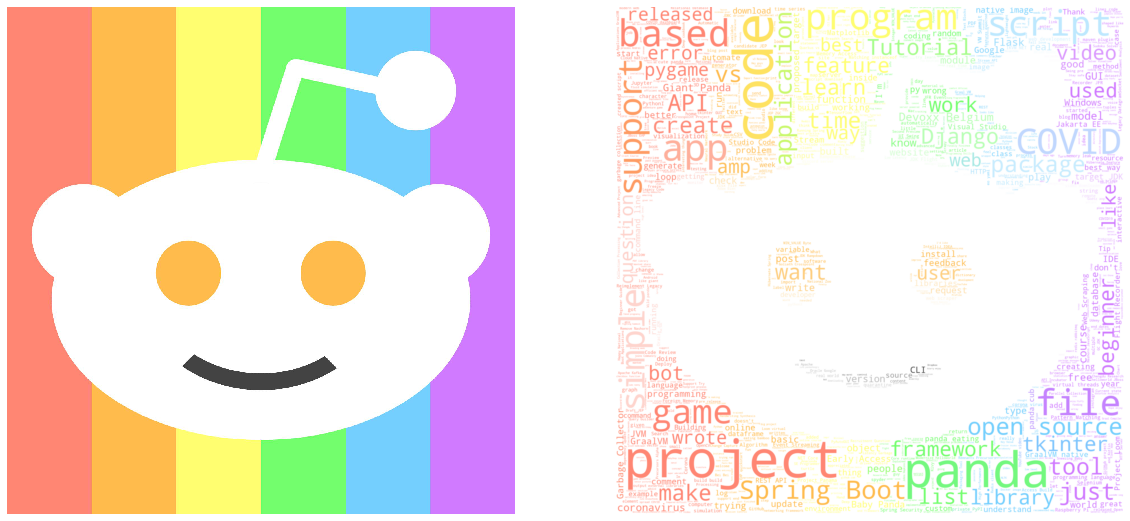

In [17]:
mask = np.array(Image.open("../images/reddit06.jpg"))
colorcloud = wordcloud.WordCloud(stopwords=custom_stop_words,
                                 background_color="white",
                                 mode="RGBA",
                                 max_words=1000,
                                 mask=mask)
colorcloud.generate(df['title'].str.cat())

image_colors = wordcloud.ImageColorGenerator(mask)
plt.figure(figsize=[7, 7])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1.imshow(mask)
ax1.axis(False)

ax2.imshow(colorcloud.recolor(color_func=image_colors),
           interpolation="bilinear")
ax2.axis(False)

plt.show();